# CREDIT CARD FRAUD DETECTION
The data is from Kaggle, Link : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

###### Context
It is important that credit card companies are able to recorgnize fradulent credit card transaction so that customers are not charged for items they did not purchase.

###### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


In [1]:
#import the important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy

In [2]:
#load the dataset
data = pd.read_csv('creditcard.csv')

In [3]:
#explore the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
print(data.shape)

(284807, 31)


In [5]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [6]:
#Sample only a fraction of the dataset to save on time and computational power
data = data.sample(frac = 0.1,random_state = 1)
print(data.shape)

(28481, 31)


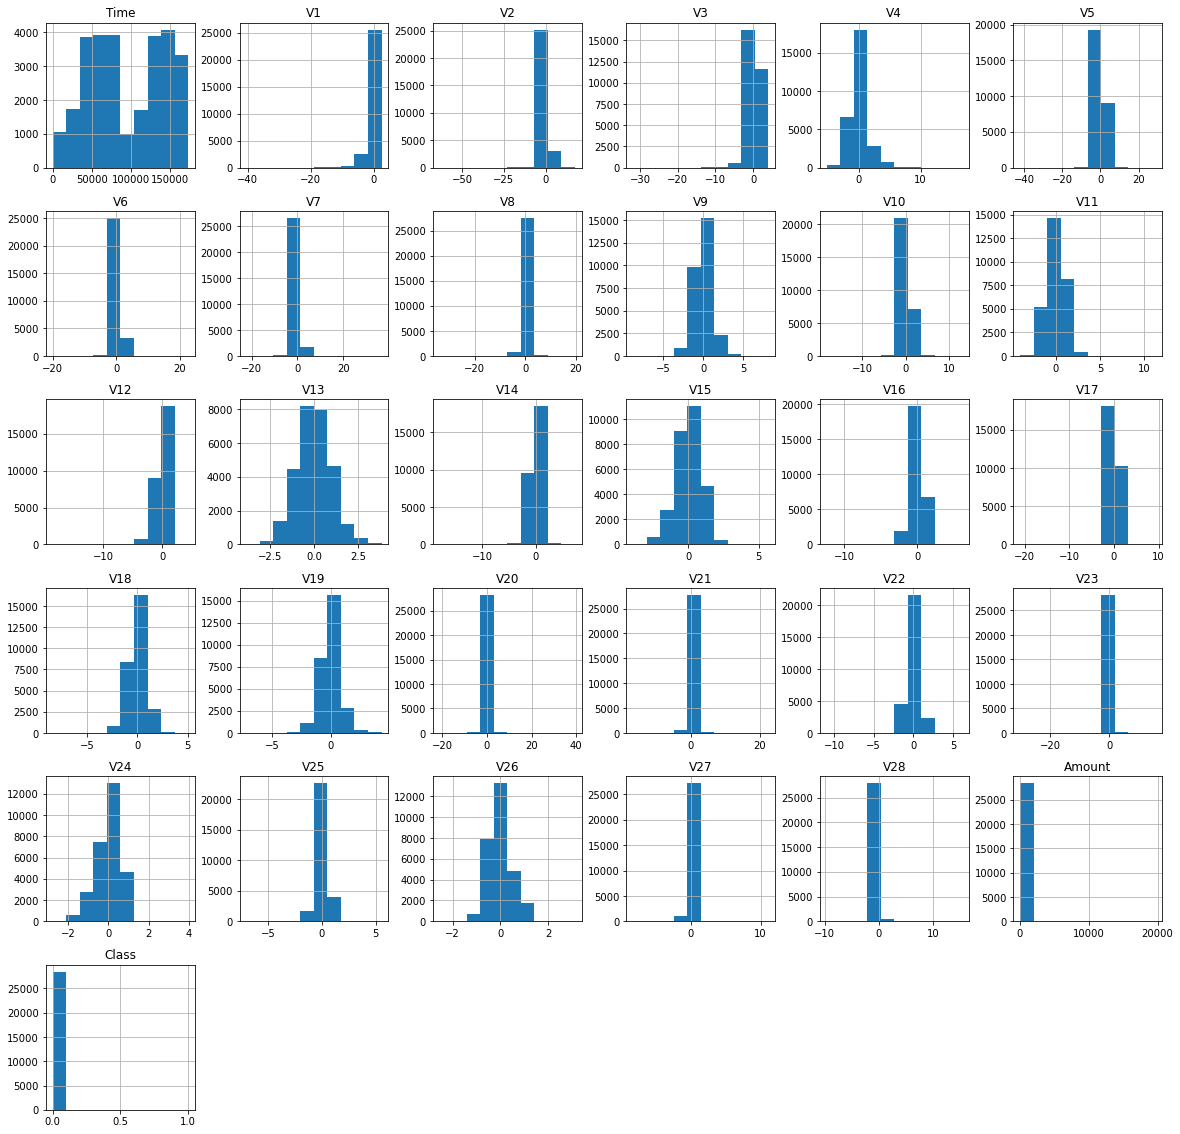

In [7]:
#Plot a histogram of each parameter
data.hist(figsize = (20, 20))
plt.show()


**From the visualization above, there are very few fraudulent transactions in comparison to valid transactions**

Lets go ahead and calculate the number of fraudlent cases that we have in our dataset anad the number of 
valid transactions so we can get an outlier fraction that is going to go into the future methods, the anomaly
detection methods.

In [8]:
#Determine the number of fradulent cases in the data
Fraud = data[data['Class']==1]
Valid = data[data['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(Fraud)))
print('Valid Cases: {}'.format(len(Valid)))

0.0017234102419808666
Fraud Cases: 49
Valid Cases: 28432


<AxesSubplot:>

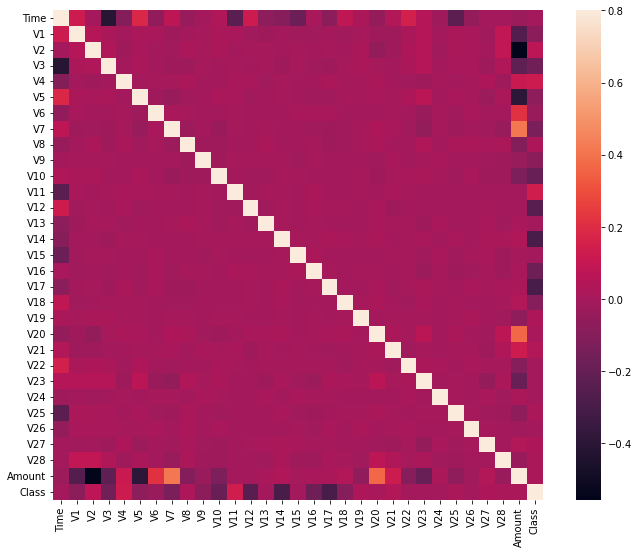

In [9]:
#Correlation Matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square=True)

In [10]:
#Get all the columns from the Dataframe
columns = data.columns.tolist()

#Filter the column to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

#Store the variable we are predicting on
target = "Class"

X = data[columns]
Y = data[target]

#print the shapes of X and Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [11]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest #Returns the Anomaly score of each sample
from sklearn.neighbors import LocalOutlierFactor #Similar to K-Nearest Neighbors

#svm would be used however it takes longer to compute the outliers especially considering the size of the dataset

#Define a Random State
state = 1
#Define outlier detection methods
classifiers = {
    "Isolation Forest" :IsolationForest(max_samples=len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    "Local Outlier Factor": LocalOutlierFactor(
    n_neighbors = 20,
    contamination = outlier_fraction)
}


In [12]:
#Lets fit the model
n_outliers = len(Fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    #fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scorer_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    #Reshape the predictions values to 0 for valid and 1 for Fraud
    y_pred[y_pred == 1]=0
    y_pred[y_pred==-1] =1
    
    n_errors = (y_pred != Y).sum()
    
    #Run classification matrix
    print('{} :{}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

Isolation Forest :71
0.99750711000316
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.28      0.29      0.28        49

    accuracy                           1.00     28481
   macro avg       0.64      0.64      0.64     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor :97
0.9965942207085425
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

